In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

## Problem 1: Clustering

A leading bank wants to develop a customer segmentation to give promotional offers to its customers. They collected a sample that summarizes the activities of users during the past few months. You are given the task to identify the segments based on credit card usage.

### Read the data, do the necessary initial steps, and exploratory data analysis (Univariate, Bi-variate, and multivariate analysis).

In [2]:
data=pd.read_csv("bank_marketing_part1_Data.csv")

In [3]:
data.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550
1,15.99,14.89,0.9064,5.363,3.582,3.336,5.144
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148
3,10.83,12.96,0.8099,5.278,2.641,5.182,5.185
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837


In [4]:
data.shape

(210, 7)

In [5]:
data.isnull().values.any()

False

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   spending                      210 non-null    float64
 1   advance_payments              210 non-null    float64
 2   probability_of_full_payment   210 non-null    float64
 3   current_balance               210 non-null    float64
 4   credit_limit                  210 non-null    float64
 5   min_payment_amt               210 non-null    float64
 6   max_spent_in_single_shopping  210 non-null    float64
dtypes: float64(7)
memory usage: 11.6 KB


In [7]:
data.duplicated().sum()

0

In [8]:
data.describe()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000


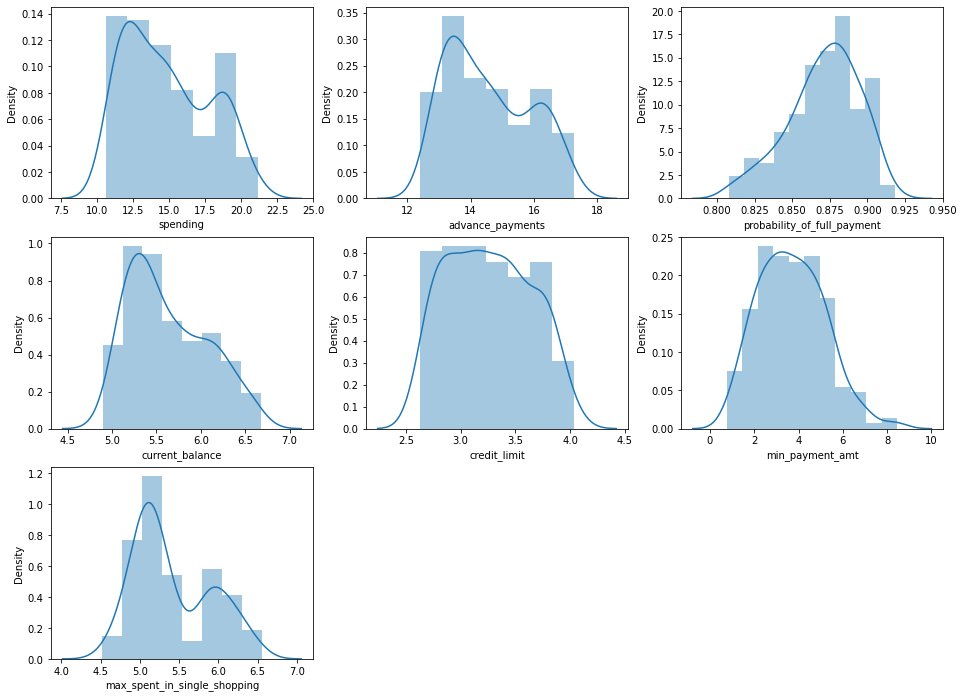

In [9]:
plt.figure(figsize=(16,12))
j=1
for i in ['spending','advance_payments','probability_of_full_payment','current_balance','credit_limit','min_payment_amt','max_spent_in_single_shopping']:
    plt.subplot(3,3,j)
    sns.distplot(data[i])
    j=j+1
    

In [10]:
plt.figure(figsize=(16,12))

for i in ['spending','advance_payments','probability_of_full_payment','current_balance','credit_limit','min_payment_amt','max_spent_in_single_shopping']:
    print(i,"Skewed: ",round(data[i].skew(),4))
    

spending Skewed:  0.3999
advance_payments Skewed:  0.3866
probability_of_full_payment Skewed:  -0.538
current_balance Skewed:  0.5255
credit_limit Skewed:  0.1344
min_payment_amt Skewed:  0.4017
max_spent_in_single_shopping Skewed:  0.5619


<Figure size 1152x864 with 0 Axes>

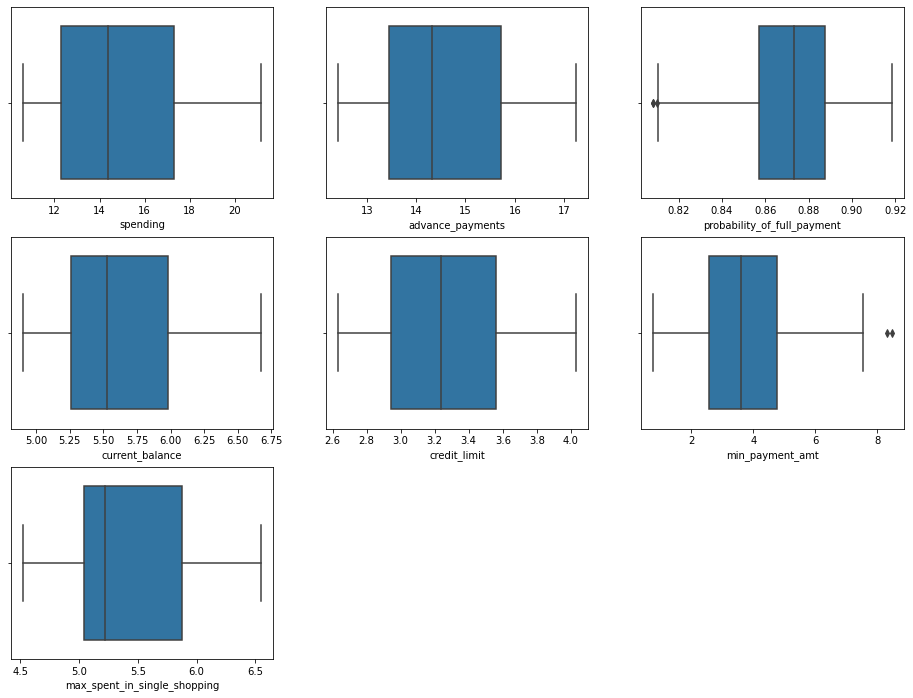

In [11]:
plt.figure(figsize=(16,12))
j=1
for i in ['spending','advance_payments','probability_of_full_payment','current_balance','credit_limit','min_payment_amt','max_spent_in_single_shopping']:
    plt.subplot(3,3,j)
    sns.boxplot(data[i])
    j=j+1

<AxesSubplot:>

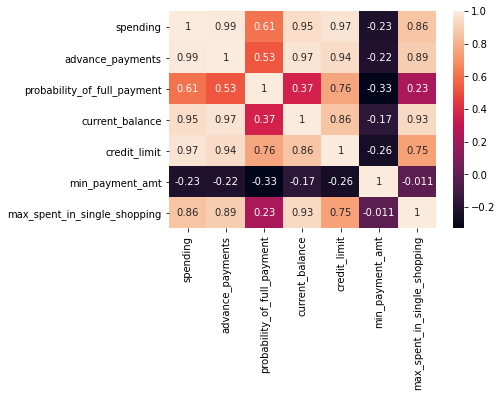

In [12]:
sns.heatmap(data.corr(), annot=True)

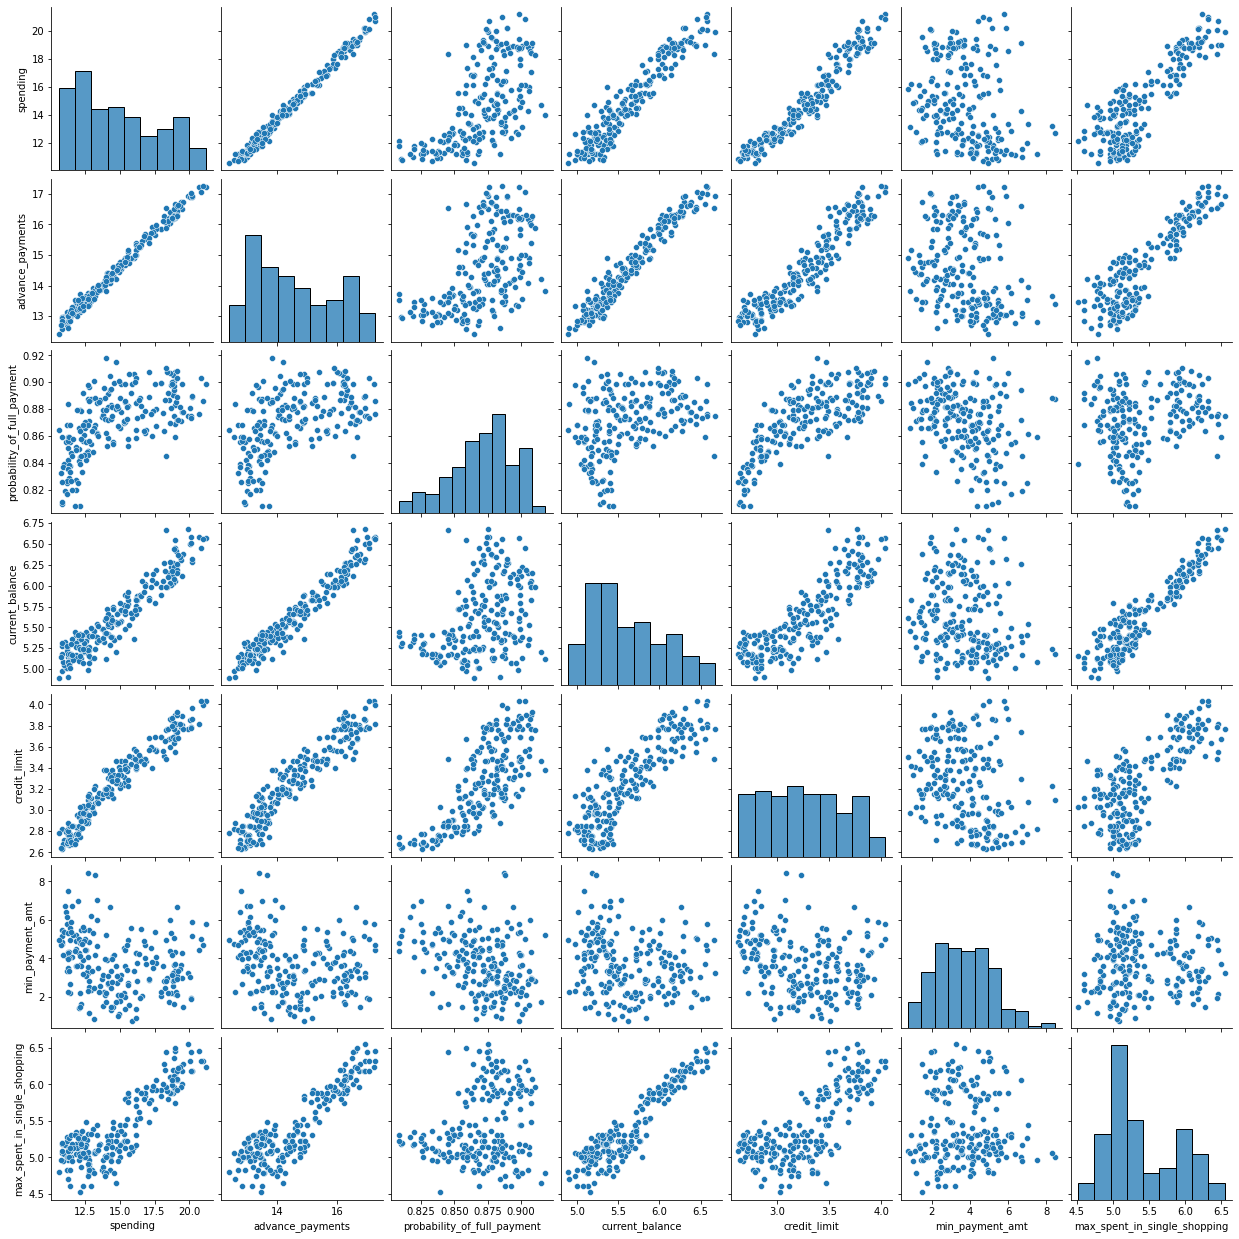

In [13]:
sns.pairplot(data);

### Do you think scaling is necessary for clustering in this case? Justify

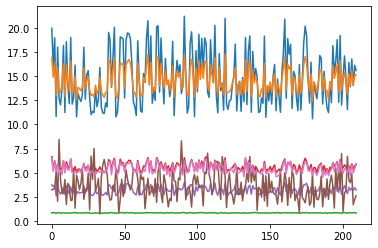

In [14]:
# prior to scaling 
plt.plot(data)
plt.show()

In [15]:
from scipy.stats import zscore
data_scaled=data.apply(zscore)
data_scaled.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
0,1.754355,1.811968,0.178230,2.367533,1.338579,-0.298806,2.328998
1,0.393582,0.253840,1.501773,-0.600744,0.858236,-0.242805,-0.538582
2,1.413300,1.428192,0.504874,1.401485,1.317348,-0.221471,1.509107
3,-1.384034,-1.227533,-2.591878,-0.793049,-1.639017,0.987884,-0.454961
4,1.082581,0.998364,1.196340,0.591544,1.155464,-1.088154,0.874813


In [16]:
data_scaled.describe()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
count,2.100000e+02,2.100000e+02,2.100000e+02,2.100000e+02,2.100000e+02,2.100000e+02,2.100000e+02
mean,9.148766e-16,1.097006e-16,1.243978e-15,-1.089076e-16,-2.994298e-16,5.302637e-16,-1.935489e-15
std,1.002389e+00,1.002389e+00,1.002389e+00,1.002389e+00,1.002389e+00,1.002389e+00,1.002389e+00
min,-1.466714e+00,-1.649686e+00,-2.668236e+00,-1.650501e+00,-1.668209e+00,-1.956769e+00,-1.813288e+00
25%,-8.879552e-01,-8.514330e-01,-5.980791e-01,-8.286816e-01,-8.349072e-01,-7.591477e-01,-7.404953e-01
50%,-1.696741e-01,-1.836639e-01,1.039927e-01,-2.376280e-01,-5.733534e-02,-6.746852e-02,-3.774588e-01
75%,8.465989e-01,8.870693e-01,7.116771e-01,7.945947e-01,8.044956e-01,7.123789e-01,9.563941e-01
max,2.181534e+00,2.065260e+00,2.006586e+00,2.367533e+00,2.055112e+00,3.170590e+00,2.328998e+00


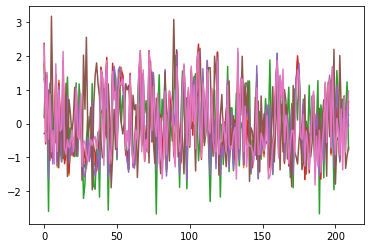

In [17]:
# Scaling the attributes.
plt.plot(data_scaled)
plt.show()

### Apply hierarchical clustering to scaled data. Identify the number of optimum clusters using Dendrogram and briefly describe them

In [18]:
wardlink = linkage(data_scaled, method = 'ward',metric='euclidean')

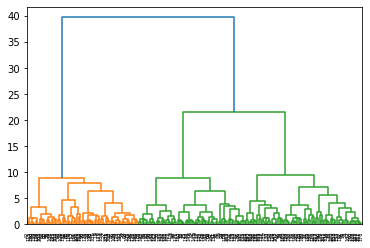

In [19]:
dend = dendrogram(wardlink)

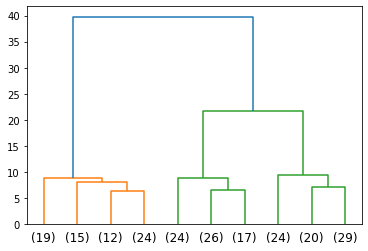

In [20]:
dend = dendrogram(wardlink,
                 truncate_mode='lastp',
                 p = 10,
                 )

In [21]:
from scipy.cluster.hierarchy import fcluster

In [22]:
clusters = fcluster(wardlink, 3, criterion='maxclust')
clusters

array([1, 3, 1, 2, 1, 2, 2, 3, 1, 2, 1, 3, 2, 1, 3, 2, 3, 2, 3, 2, 2, 2,
       1, 2, 3, 1, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 1, 1, 3, 1, 1,
       2, 2, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 3, 2, 2, 3, 3, 1,
       1, 3, 1, 2, 3, 2, 1, 1, 2, 1, 3, 2, 1, 3, 3, 3, 3, 1, 2, 3, 3, 1,
       1, 2, 3, 1, 3, 2, 2, 1, 1, 1, 2, 1, 2, 1, 3, 1, 3, 1, 1, 2, 2, 1,
       3, 3, 1, 2, 2, 1, 3, 3, 2, 1, 3, 2, 2, 2, 3, 3, 1, 2, 3, 3, 2, 3,
       3, 1, 2, 1, 1, 2, 1, 3, 3, 3, 2, 2, 3, 2, 1, 2, 3, 2, 3, 2, 3, 3,
       3, 3, 3, 2, 3, 1, 1, 2, 1, 1, 1, 2, 1, 3, 3, 3, 3, 2, 3, 1, 1, 1,
       3, 3, 1, 2, 3, 3, 3, 3, 1, 1, 3, 3, 3, 2, 3, 3, 2, 1, 3, 1, 1, 2,
       1, 2, 3, 1, 3, 2, 1, 3, 1, 3, 1, 3], dtype=int32)

In [23]:
data['clusters'] = clusters

In [24]:
data.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,clusters
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550,1
1,15.99,14.89,0.9064,5.363,3.582,3.336,5.144,3
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148,1
3,10.83,12.96,0.8099,5.278,2.641,5.182,5.185,2
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837,1


In [25]:
data.clusters.value_counts().sort_index()

1    70
2    67
3    73
Name: clusters, dtype: int64

In [26]:
aggdata=data.groupby('clusters').mean()
aggdata['Freq']=data.clusters.value_counts().sort_index()
aggdata

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,Freq
clusters,,,,,,,,
1,18.371429,16.145429,0.884400,6.158171,3.684629,3.639157,6.017371,70
2,11.872388,13.257015,0.848072,5.238940,2.848537,4.949433,5.122209,67
3,14.199041,14.233562,0.879190,5.478233,3.226452,2.612181,5.086178,73


### Apply K-Means clustering on scaled data and determine optimum clusters. Apply elbow curve and silhouette score. Explain the results properly. Interpret and write inferences on the finalized clusters.

#### Calculating WSS for  values of K - Elbow Method

In [27]:
wss =[] 
for i in range(1,11):
    KM = KMeans(n_clusters=i,random_state=1)
    KM.fit(data_scaled)
    wss.append(KM.inertia_)

In [28]:
print(wss)

[1469.9999999999995, 659.1717544870411, 430.65897315130064, 371.301721277542, 327.9608240079031, 290.5900305968219, 264.83153087478144, 240.6837259501598, 220.85285825594738, 206.3829103601579]


<AxesSubplot:>

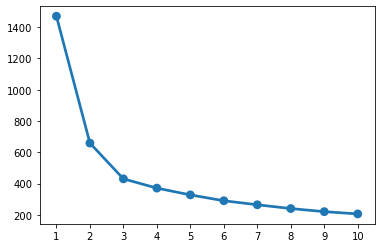

In [29]:
a=[1,2,3,4,5,6,7,8,9,10]
sns.pointplot(a, wss)

In [30]:
ss=[]
for k in range(2,10):
    k_means=KMeans(n_clusters=k,random_state=1)
    k_means.fit(data_scaled)
    labels=k_means.labels_
    print("For cluster=",k,":",silhouette_score(data_scaled,labels,random_state=1))

For cluster= 2 : 0.46577247686580914
For cluster= 3 : 0.40072705527512986
For cluster= 4 : 0.32757426605518075
For cluster= 5 : 0.27836514155320397
For cluster= 6 : 0.28389221057730224
For cluster= 7 : 0.26934344290163237
For cluster= 8 : 0.2578633719728751
For cluster= 9 : 0.25981172609715214


In [31]:
k_means = KMeans(n_clusters = 3,random_state=1)
k_means.fit(data_scaled)
labels = k_means.labels_
labels

array([1, 2, 1, 0, 1, 0, 0, 2, 1, 0, 1, 2, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0,
       1, 0, 2, 1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1,
       0, 0, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 2, 0, 0, 2, 2, 1,
       1, 2, 1, 0, 2, 0, 1, 1, 0, 1, 2, 0, 1, 2, 2, 2, 2, 1, 0, 2, 1, 2,
       1, 0, 2, 1, 2, 0, 0, 1, 1, 1, 0, 1, 2, 1, 2, 1, 2, 1, 1, 0, 0, 1,
       2, 2, 1, 0, 0, 1, 2, 2, 0, 1, 2, 0, 0, 0, 2, 2, 1, 0, 2, 2, 0, 2,
       2, 1, 0, 1, 1, 0, 1, 2, 2, 2, 0, 0, 2, 0, 1, 0, 2, 0, 2, 0, 2, 2,
       0, 2, 2, 0, 2, 1, 1, 0, 1, 1, 1, 0, 2, 2, 2, 0, 2, 0, 2, 1, 1, 1,
       2, 0, 2, 0, 2, 2, 2, 2, 1, 1, 0, 2, 2, 0, 0, 2, 0, 1, 2, 1, 1, 0,
       1, 0, 2, 1, 2, 0, 1, 2, 1, 2, 2, 2])

In [32]:
data_df=data.drop(['clusters'],axis=1)

In [33]:
data_df.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550
1,15.99,14.89,0.9064,5.363,3.582,3.336,5.144
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148
3,10.83,12.96,0.8099,5.278,2.641,5.182,5.185
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837


In [34]:
data_df["Clus_kmeans"] = labels
data_df.head()


,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,Clus_kmeans
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550,1
1,15.99,14.89,0.9064,5.363,3.582,3.336,5.144,2
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148,1
3,10.83,12.96,0.8099,5.278,2.641,5.182,5.185,0
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837,1


#### Cluster Profiling

In [35]:
data_df.Clus_kmeans.value_counts().sort_index()

0    72
1    67
2    71
Name: Clus_kmeans, dtype: int64

In [36]:
clust_profile=data_df.groupby('Clus_kmeans').mean()
clust_profile['freq']=data_df.Clus_kmeans.value_counts().sort_index()
clust_profile

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,freq
Clus_kmeans,,,,,,,,
0,11.856944,13.247778,0.848253,5.231750,2.849542,4.742389,5.101722,72
1,18.495373,16.203433,0.884210,6.175687,3.697537,3.632373,6.041701,67
2,14.437887,14.337746,0.881597,5.514577,3.259225,2.707341,5.120803,71


### Describe cluster profiles for the clusters defined. Recommend different promotional strategies for different clusters.

In [37]:
clust_profile=data_df.groupby('Clus_kmeans').mean()
clust_profile['freq']=data_df.Clus_kmeans.value_counts().sort_index()
clust_profile

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,freq
Clus_kmeans,,,,,,,,
0,11.856944,13.247778,0.848253,5.231750,2.849542,4.742389,5.101722,72
1,18.495373,16.203433,0.884210,6.175687,3.697537,3.632373,6.041701,67
2,14.437887,14.337746,0.881597,5.514577,3.259225,2.707341,5.120803,71


## Problem 2: CART-RF-ANN

An Insurance firm providing tour insurance is facing higher claim frequency. The management decides to collect data from the past few years. You are assigned the task to make a model which predicts the claim status and provide recommendations to management. Use CART, RF & ANN and compare the models' performances in train and test sets.

### Read the data, do the necessary initial steps, and exploratory data analysis (Univariate, Bi-variate, and multivariate analysis).

In [38]:
df=pd.read_csv('insurance_part2_data.csv')

In [39]:
df.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,C2B,Airlines,No,0.70,Online,7,2.51,Customised Plan,ASIA
1,36,EPX,Travel Agency,No,0.00,Online,34,20.00,Customised Plan,ASIA
2,39,CWT,Travel Agency,No,5.94,Online,3,9.90,Customised Plan,Americas
3,36,EPX,Travel Agency,No,0.00,Online,4,26.00,Cancellation Plan,ASIA
4,33,JZI,Airlines,No,6.30,Online,53,18.00,Bronze Plan,ASIA


In [40]:
df.shape

(3000, 10)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           3000 non-null   int64  
 1   Agency_Code   3000 non-null   object 
 2   Type          3000 non-null   object 
 3   Claimed       3000 non-null   object 
 4   Commision     3000 non-null   float64
 5   Channel       3000 non-null   object 
 6   Duration      3000 non-null   int64  
 7   Sales         3000 non-null   float64
 8   Product Name  3000 non-null   object 
 9   Destination   3000 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 234.5+ KB


#### Check for duplicate data

In [42]:
df.duplicated().sum()/df.shape[0]*100

4.633333333333333

In [43]:
# from pandas_profiling import ProfileReport
# report = ProfileReport(df)
# report.to_file("Report.html")

#### Univariate Analysis

In [44]:
df.describe()

,Age,Commision,Duration,Sales
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,38.091000,14.529203,70.001333,60.249913
std,10.463518,25.481455,134.053313,70.733954
min,8.000000,0.000000,-1.000000,0.000000
25%,32.000000,0.000000,11.000000,20.000000
50%,36.000000,4.630000,26.500000,33.000000
75%,42.000000,17.235000,63.000000,69.000000
max,84.000000,210.210000,4580.000000,539.000000


In [45]:
df.describe(include=object)

,Agency_Code,Type,Claimed,Channel,Product Name,Destination
count,3000,3000,3000,3000,3000,3000
unique,4,2,2,2,5,3
top,EPX,Travel Agency,No,Online,Customised Plan,ASIA
freq,1365,1837,2076,2954,1136,2465


In [46]:
for i in ['Age','Commision','Duration','Sales']:
    print(i,"Skewed: ",round(df[i].skew(),4))

Age Skewed:  1.1497
Commision Skewed:  3.1489
Duration Skewed:  13.7847
Sales Skewed:  2.3811


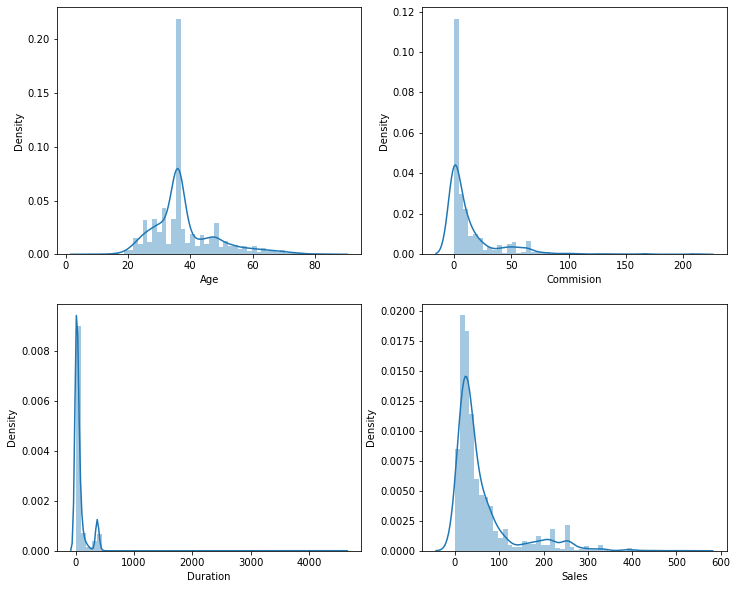

In [47]:
plt.figure(figsize=(12,10))
j=1
for i in ['Age','Commision','Duration','Sales']:
    plt.subplot(2,2,j)
    sns.distplot(df[i])
    j=j+1
plt.show()

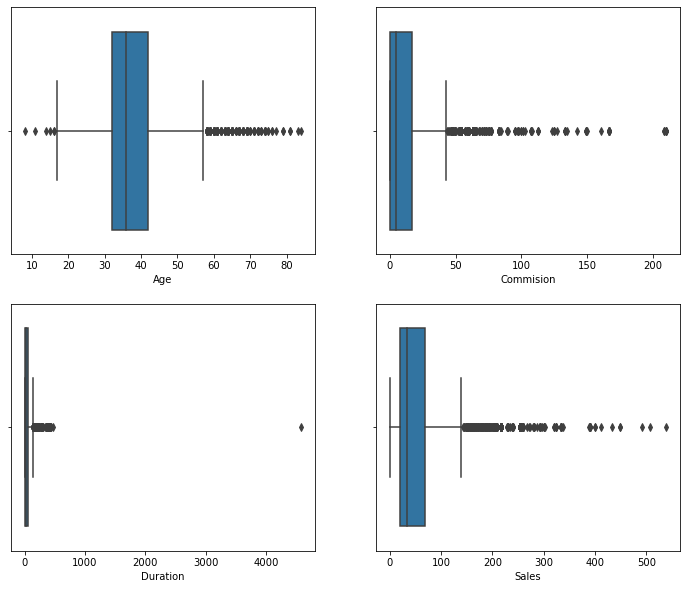

In [48]:
plt.figure(figsize=(12,10))
j=1
for i in ['Age','Commision','Duration','Sales']:
    plt.subplot(2,2,j)
    sns.boxplot(df[i])
    j=j+1

In [49]:
for column in df[['Agency_Code','Type','Claimed','Channel','Product Name','Destination']]:
    print(column.upper(),': ',df[column].nunique())
    print(df[column].value_counts())
    print('\n****************************\n')

AGENCY_CODE :  4
EPX    1365
C2B     924
CWT     472
JZI     239
Name: Agency_Code, dtype: int64

****************************

TYPE :  2
Travel Agency    1837
Airlines         1163
Name: Type, dtype: int64

****************************

CLAIMED :  2
No     2076
Yes     924
Name: Claimed, dtype: int64

****************************

CHANNEL :  2
Online     2954
Offline      46
Name: Channel, dtype: int64

****************************

PRODUCT NAME :  5
Customised Plan      1136
Cancellation Plan     678
Bronze Plan           650
Silver Plan           427
Gold Plan             109
Name: Product Name, dtype: int64

****************************

DESTINATION :  3
ASIA        2465
Americas     320
EUROPE       215
Name: Destination, dtype: int64

****************************



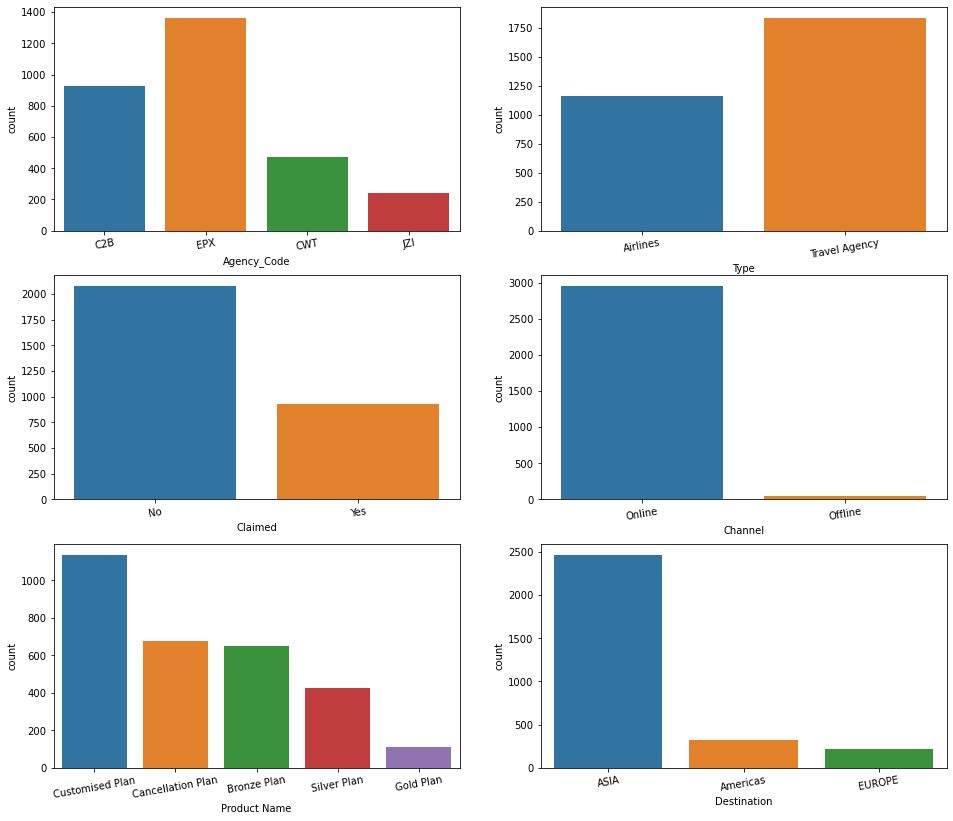

In [50]:
plt.figure(figsize=(16,14))

j=1
for i in ['Agency_Code','Type','Claimed','Channel','Product Name','Destination']:
    plt.subplot(3,2,j)
    sns.countplot(df[i])
    plt.xticks(rotation=10)
    j=j+1

#### Bi-variate

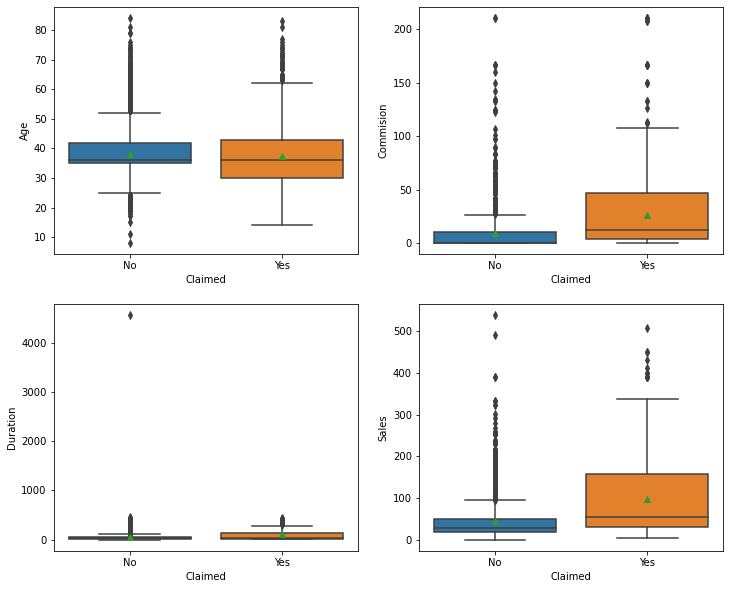

In [51]:
plt.figure(figsize=(12,10))
j=1
for i in ['Age','Commision','Duration','Sales']:
    plt.subplot(2,2,j)
    sns.boxplot(y=df[i], x=df['Claimed'],showmeans=True)
    j=j+1

<AxesSubplot:xlabel='Agency_Code'>

<Figure size 1152x1008 with 0 Axes>

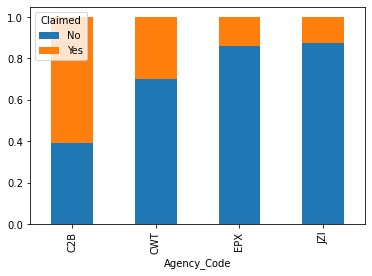

In [52]:
plt.figure(figsize=(16,14))
pd.crosstab(df['Agency_Code'], df['Claimed'], normalize='index').plot(kind='bar', stacked=True)


<AxesSubplot:xlabel='Type'>

<Figure size 1152x1008 with 0 Axes>

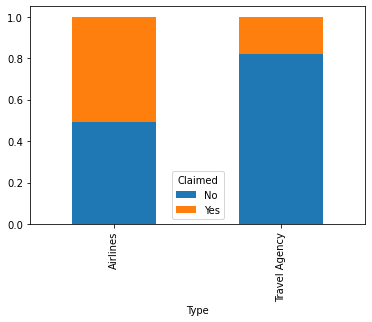

In [53]:
plt.figure(figsize=(16,14))
pd.crosstab(df['Type'], df['Claimed'], normalize='index').plot(kind='bar', stacked=True)


<AxesSubplot:xlabel='Channel'>

<Figure size 1152x1008 with 0 Axes>

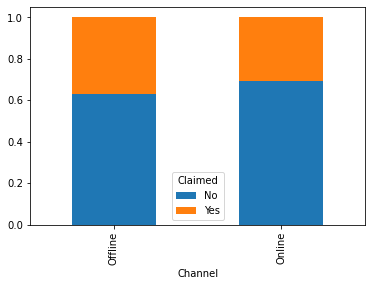

In [54]:
plt.figure(figsize=(16,14))
pd.crosstab(df['Channel'], df['Claimed'], normalize='index').plot(kind='bar', stacked=True)


<AxesSubplot:xlabel='Product Name'>

<Figure size 1152x1008 with 0 Axes>

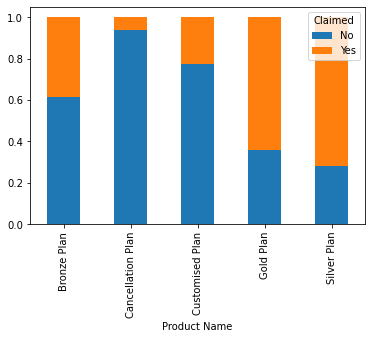

In [55]:
plt.figure(figsize=(16,14))
pd.crosstab(df['Product Name'], df['Claimed'], normalize='index').plot(kind='bar', stacked=True)


<AxesSubplot:xlabel='Destination'>

<Figure size 1152x1008 with 0 Axes>

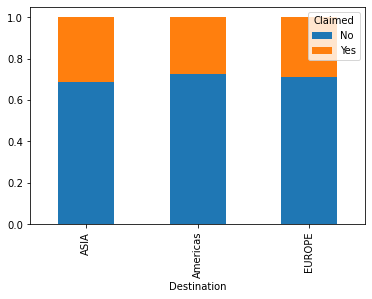

In [56]:
plt.figure(figsize=(16,14))
pd.crosstab(df['Destination'], df['Claimed'], normalize='index').plot(kind='bar', stacked=True)


#### multivariate

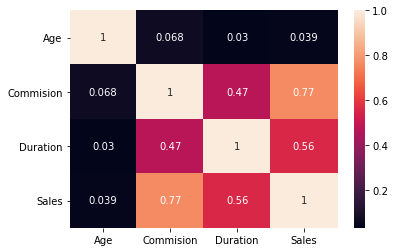

In [57]:
sns.heatmap(df.corr(), annot=True);

<Figure size 1152x864 with 0 Axes>

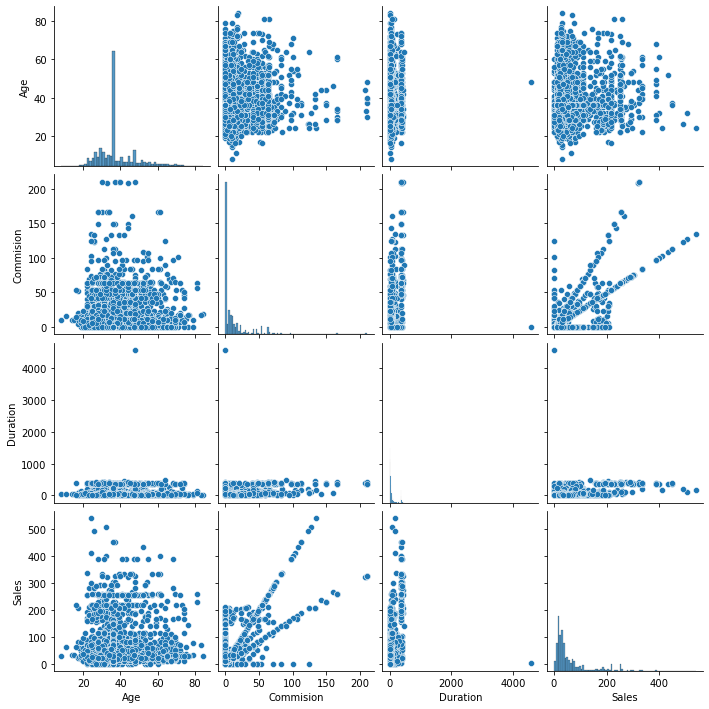

In [58]:
plt.figure(figsize=(16,12))
sns.pairplot(df)
plt.show()

### Data Split: Split the data into test and train, build classification model CART, Random Forest, Artificial Neural Network

#### Converting all object to categorical codes.

In [59]:
for feature in df.columns: 
    if df[feature].dtype == 'object': 
        print('\n')
        print('feature:',feature)
        print(pd.Categorical(df[feature].unique()))
        print(pd.Categorical(df[feature].unique()).codes)
        df[feature] = pd.Categorical(df[feature]).codes



feature: Agency_Code
['C2B', 'EPX', 'CWT', 'JZI']
Categories (4, object): ['C2B', 'CWT', 'EPX', 'JZI']
[0 2 1 3]


feature: Type
['Airlines', 'Travel Agency']
Categories (2, object): ['Airlines', 'Travel Agency']
[0 1]


feature: Claimed
['No', 'Yes']
Categories (2, object): ['No', 'Yes']
[0 1]


feature: Channel
['Online', 'Offline']
Categories (2, object): ['Offline', 'Online']
[1 0]


feature: Product Name
['Customised Plan', 'Cancellation Plan', 'Bronze Plan', 'Silver Plan', 'Gold Plan']
Categories (5, object): ['Bronze Plan', 'Cancellation Plan', 'Customised Plan', 'Gold Plan', 'Silver Plan']
[2 1 0 4 3]


feature: Destination
['ASIA', 'Americas', 'EUROPE']
Categories (3, object): ['ASIA', 'Americas', 'EUROPE']
[0 1 2]


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           3000 non-null   int64  
 1   Agency_Code   3000 non-null   int8   
 2   Type          3000 non-null   int8   
 3   Claimed       3000 non-null   int8   
 4   Commision     3000 non-null   float64
 5   Channel       3000 non-null   int8   
 6   Duration      3000 non-null   int64  
 7   Sales         3000 non-null   float64
 8   Product Name  3000 non-null   int8   
 9   Destination   3000 non-null   int8   
dtypes: float64(2), int64(2), int8(6)
memory usage: 111.5 KB


In [61]:
df.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,0,0,0,0.70,1,7,2.51,2,0
1,36,2,1,0,0.00,1,34,20.00,2,0
2,39,1,1,0,5.94,1,3,9.90,2,1
3,36,2,1,0,0.00,1,4,26.00,1,0
4,33,3,0,0,6.30,1,53,18.00,0,0


In [62]:
X = df.drop("Claimed", axis=1)

y = df.pop("Claimed")

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, train_labels, test_labels = train_test_split(X, y, test_size=.30, random_state=1)

In [64]:
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('train_labels',train_labels.shape)
print('test_labels',test_labels.shape)

X_train (2100, 9)
X_test (900, 9)
train_labels (2100,)
test_labels (900,)


#### model-1 Building a Decision Tree Classifier

In [65]:
dt_model= DecisionTreeClassifier(criterion='gini')

In [66]:
dt_model.fit(X_train,train_labels)

DecisionTreeClassifier()

#### optimal Values for decision tree
#### grid search for finding out optimal values for the hyper parameters

In [67]:
param_grid = {
    'criterion': ['gini'],
    'max_depth': [10,12,14,16],  
    'min_samples_leaf': [20,25,50],   
    'min_samples_split': [100,150,200,250],  
}

dtcl = DecisionTreeClassifier(random_state=1)

grid_search = GridSearchCV(estimator = dtcl, param_grid = param_grid, cv = 10)

In [68]:
grid_search.fit(X_train, train_labels)

best_grid_dt = grid_search.best_estimator_
best_grid_dt

DecisionTreeClassifier(max_depth=10, min_samples_leaf=25, min_samples_split=150,
                       random_state=1)

In [69]:
print(
    pd.DataFrame(best_grid_dt.feature_importances_,
                 columns=["Imp"],
                 index=X_train.columns).sort_values('Imp', ascending=False))

                   Imp
Agency_Code   0.563514
Sales         0.246609
Product Name  0.071979
Age           0.046292
Duration      0.043429
Commision     0.021206
Type          0.006972
Channel       0.000000
Destination   0.000000


#### Predicting on Training and Test dataset

In [70]:
ytrain_predict_dt = best_grid_dt.predict(X_train)
ytest_predict_dt = best_grid_dt.predict(X_test)

#### Getting the Predicted Classes and Probs

In [71]:
ytest_predict_prob_dt=best_grid_dt.predict_proba(X_test)
ytest_predict_prob_dt
pd.DataFrame(ytest_predict_prob_dt).head()

,0,1
0,0.935714,0.064286
1,0.555556,0.444444
2,0.292035,0.707965
3,0.172414,0.827586
4,0.909774,0.090226


#### model-2 Building a Random Forest Classifier

In [72]:
rfcl=RandomForestClassifier(n_estimators=100,max_features=6,random_state=1)
rfcl=rfcl.fit(X_train,train_labels)

#### grid search for finding out optimal values for the hyper parameters

In [73]:
param_grid = {
    'max_depth': [10,12,15],
    'max_features': [3,4,5],
    'min_samples_split': [40,45,60], 
    'n_estimators': [101] 
}

rfcl = RandomForestClassifier(random_state=0)

grid_search = GridSearchCV(estimator = rfcl, param_grid = param_grid, cv = 10)

In [74]:
grid_search.fit(X_train, train_labels)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [10, 12, 15], 'max_features': [3, 4, 5],
                         'min_samples_split': [40, 45, 60],
                         'n_estimators': [101]})

In [75]:
grid_search.best_params_

{'max_depth': 12,
 'max_features': 3,
 'min_samples_split': 40,
 'n_estimators': 101}

In [76]:
best_grid_rfcl = grid_search.best_estimator_

In [77]:
print(
    pd.DataFrame(best_grid_rfcl.feature_importances_,
                 columns=["Imp"],
                 index=X_train.columns).sort_values('Imp', ascending=False))

                   Imp
Agency_Code   0.227565
Sales         0.174086
Product Name  0.166902
Commision     0.145033
Duration      0.128431
Age           0.087442
Type          0.045076
Destination   0.015456
Channel       0.010010


#### Predicting on Training and Test dataset

In [78]:
ytrain_predict_rfcl = best_grid_rfcl.predict(X_train)
ytest_predict_rfcl = best_grid_rfcl.predict(X_test)

#### Getting the Predicted Classes and Probs

In [79]:
ytest_predict_prob_rfcl=best_grid_rfcl.predict_proba(X_test)
ytest_predict_prob_rfcl
pd.DataFrame(ytest_predict_prob_rfcl).head()

,0,1
0,0.769985,0.230015
1,0.529376,0.470624
2,0.390833,0.609167
3,0.242224,0.757776
4,0.960587,0.039413


#### Model-3 Building a Neural Network Classifier

#### scale the data

In [80]:
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler()
X_train_ncc = std_scale.fit_transform(X_train)
X_test_ncc = std_scale.transform(X_test)

In [81]:
clf=MLPClassifier(hidden_layer_sizes=100,max_iter=500,solver='sgd',random_state=1,tol=0.01)

In [82]:
clf.fit(X_train_ncc,train_labels)

MLPClassifier(hidden_layer_sizes=100, max_iter=500, random_state=1,
              solver='sgd', tol=0.01)

#### grid search for finding out optimal values for the hyper parameters

In [83]:
param_grid = {
    'hidden_layer_sizes': [8], 
    'max_iter': [2500,3000], 
    'solver': ['adam', 'sgd'], 
    'tol': [0.001, 0.01], 
}

nncl = MLPClassifier(random_state=1)

grid_search = GridSearchCV(estimator = nncl, param_grid = param_grid, cv = 5)

In [84]:
grid_search.fit(X_train_ncc,train_labels)
grid_search.best_params_

{'hidden_layer_sizes': 8, 'max_iter': 2500, 'solver': 'adam', 'tol': 0.001}

In [85]:
best_grid_nnc = grid_search.best_estimator_
best_grid_nnc

MLPClassifier(hidden_layer_sizes=8, max_iter=2500, random_state=1, tol=0.001)

#### Predicting the Training and Testing data

In [86]:
ytrain_predict_nnc = best_grid_nnc.predict(X_train_ncc)
ytest_predict_nnc = best_grid_nnc.predict(X_test_ncc)

#### Getting the Predicted Classes and Probs

In [87]:
ytest_predict_prob_nnc=best_grid_nnc.predict_proba(X_test_ncc)
ytest_predict_prob_nnc
pd.DataFrame(ytest_predict_prob_nnc).head()

,0,1
0,0.812356,0.187644
1,0.682152,0.317848
2,0.604310,0.395690
3,0.316782,0.683218
4,0.907804,0.092196


### Performance Metrics: Comment and Check the performance of Predictions on Train and Test sets using Accuracy, Confusion Matrix, Plot ROC curve and get ROC_AUC score, classification reports for each model. 

#### CART Confusion Matrix for the training set

In [88]:
confusion_matrix(train_labels, ytrain_predict_dt)

array([[1332,  139],
       [ 282,  347]], dtype=int64)

#### Accuracy of the training data

In [89]:
cart_train_acc=best_grid_dt.score(X_train,train_labels) 
cart_train_acc

0.7995238095238095

 #### CART Classification Report for the training data

In [90]:
print(classification_report(train_labels, ytrain_predict_dt))

              precision    recall  f1-score   support

           0       0.83      0.91      0.86      1471
           1       0.71      0.55      0.62       629

    accuracy                           0.80      2100
   macro avg       0.77      0.73      0.74      2100
weighted avg       0.79      0.80      0.79      2100



#### AUC and ROC for the training data of the CART

AUC: 0.845


Text(0, 0.5, 'True Positive Rate')

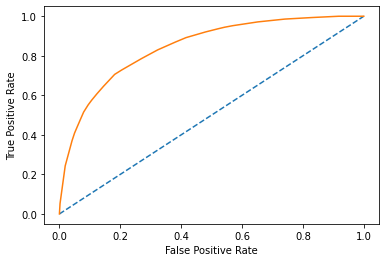

In [91]:
probs = best_grid_dt.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
cart_train_auc = roc_auc_score(train_labels, probs)
print('AUC: %.3f' % cart_train_auc)
# calculate roc curve
cart_train_fpr, cart_train_tpr, cart_train_thresholds = roc_curve(train_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(cart_train_fpr, cart_train_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [92]:
cart_metrics=classification_report(train_labels, ytrain_predict_dt,output_dict=True)
df=pd.DataFrame(cart_metrics).transpose()
cart_train_f1=round(df.loc["1"][2],2)
cart_train_recall=round(df.loc["1"][1],2)
cart_train_precision=round(df.loc["1"][0],2)
print ('cart_train_precision ',cart_train_precision)
print ('cart_train_recall ',cart_train_recall)
print ('cart_train_f1 ',cart_train_f1)

cart_train_precision  0.71
cart_train_recall  0.55
cart_train_f1  0.62


#### CART Confusion Matrix for the test set

In [93]:
confusion_matrix(test_labels, ytest_predict_dt)

array([[557,  48],
       [171, 124]], dtype=int64)

#### Accuracy of the test data

In [94]:
cart_test_acc=best_grid_dt.score(X_test,test_labels) 
cart_test_acc

0.7566666666666667

#### CART Classification Report for the test data

In [95]:
print(classification_report(test_labels, ytest_predict_dt))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       605
           1       0.72      0.42      0.53       295

    accuracy                           0.76       900
   macro avg       0.74      0.67      0.68       900
weighted avg       0.75      0.76      0.74       900



In [96]:
cart_metrics=classification_report(test_labels, ytest_predict_dt,output_dict=True)
df=pd.DataFrame(cart_metrics).transpose()
cart_test_precision=round(df.loc["1"][0],2)
cart_test_recall=round(df.loc["1"][1],2)
cart_test_f1=round(df.loc["1"][2],2)
print ('cart_test_precision ',cart_test_precision)
print ('cart_test_recall ',cart_test_recall)
print ('cart_test_f1 ',cart_test_f1)

cart_test_precision  0.72
cart_test_recall  0.42
cart_test_f1  0.53


#### AUC and ROC for the test data of the CART

AUC: 0.799


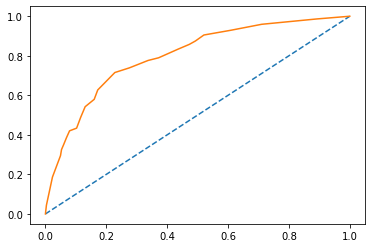

In [97]:
probs = best_grid_dt.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
cart_test_auc = roc_auc_score(test_labels, probs)
print('AUC: %.3f' % cart_test_auc)
# calculate roc curve
cart_test_fpr, cart_test_tpr, cart_testthresholds = roc_curve(test_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(cart_test_fpr, cart_test_tpr)

#### RF Confusion Matrix for the training set

In [98]:
confusion_matrix(train_labels, ytrain_predict_rfcl)

array([[1350,  121],
       [ 235,  394]], dtype=int64)

#### Accuracy of the training data

In [99]:
rf_train_acc=best_grid_rfcl.score(X_train,train_labels) 
rf_train_acc

0.8304761904761905

#### RF Classification Report for the training data

In [100]:
print(classification_report(train_labels, ytrain_predict_rfcl))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1471
           1       0.77      0.63      0.69       629

    accuracy                           0.83      2100
   macro avg       0.81      0.77      0.79      2100
weighted avg       0.83      0.83      0.83      2100



In [101]:
rf_metrics=classification_report(train_labels, ytrain_predict_rfcl,output_dict=True)
df=pd.DataFrame(rf_metrics).transpose()
rf_train_precision=round(df.loc["1"][0],2)
rf_train_recall=round(df.loc["1"][1],2)
rf_train_f1=round(df.loc["1"][2],2)
print ('rf_train_precision ',rf_train_precision)
print ('rf_train_recall ',rf_train_recall)
print ('rf_train_f1 ',rf_train_f1)

rf_train_precision  0.77
rf_train_recall  0.63
rf_train_f1  0.69


#### AUC and ROC for the training data of the RF

AUC: 0.894


Text(0, 0.5, 'True Positive Rate')

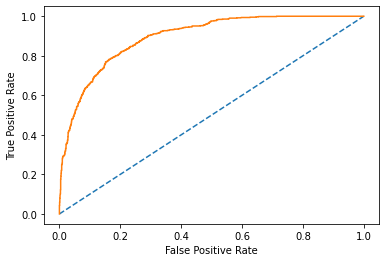

In [102]:
probs = best_grid_rfcl.predict_proba(X_train)
# keep probabilities for the positive outcome only  rf_train_auc
probs = probs[:, 1]
# calculate AUC
rf_train_auc = roc_auc_score(train_labels, probs)
print('AUC: %.3f' % rf_train_auc)
# calculate roc curve rf_train_fpr
rf_train_fpr, rf_train_tpr, rf_train_thresholds = roc_curve(train_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(rf_train_fpr, rf_train_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

####  RF Confusion Matrix for the testing set

In [103]:
confusion_matrix(test_labels, ytest_predict_rfcl)

array([[553,  52],
       [159, 136]], dtype=int64)

#### Accuracy of the testing data

In [104]:
rf_test_acc=best_grid_rfcl.score(X_test,test_labels) 
rf_test_acc

0.7655555555555555

#### RF Classification Report for the testing data

In [105]:
print(classification_report(test_labels, ytest_predict_rfcl))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       605
           1       0.72      0.46      0.56       295

    accuracy                           0.77       900
   macro avg       0.75      0.69      0.70       900
weighted avg       0.76      0.77      0.75       900



In [106]:
rf_metrics=classification_report(test_labels, ytest_predict_rfcl,output_dict=True)
df=pd.DataFrame(rf_metrics).transpose()
rf_test_precision=round(df.loc["1"][0],2)
rf_test_recall=round(df.loc["1"][1],2)
rf_test_f1=round(df.loc["1"][2],2)
print ('rf_test_precision ',rf_test_precision)
print ('rf_test_recall ',rf_test_recall)
print ('rf_test_f1 ',rf_test_f1)

rf_test_precision  0.72
rf_test_recall  0.46
rf_test_f1  0.56


#### AUC and ROC for the testing data of the RF

AUC: 0.824


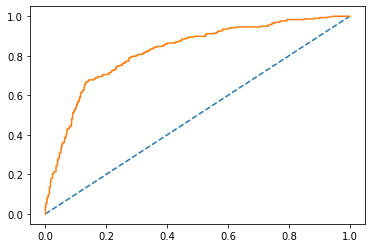

In [107]:
probs = best_grid_rfcl.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
rf_test_auc = roc_auc_score(test_labels, probs)
print('AUC: %.3f' % rf_test_auc)
# calculate roc curve
rf_test_fpr, rf_test_tpr, cart_testthresholds = roc_curve(test_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(rf_test_fpr, rf_test_tpr)

#### ANN Confusion Matrix for the training set

In [108]:
confusion_matrix(train_labels, ytrain_predict_nnc)

array([[1308,  163],
       [ 328,  301]], dtype=int64)

#### Accuracy of the training data

In [109]:
ann_train_acc=best_grid_nnc.score(X_train_ncc,train_labels) 
ann_train_acc

0.7661904761904762

#### ANN Classification Report for the trainig data

In [110]:
print(classification_report(train_labels, ytrain_predict_nnc))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84      1471
           1       0.65      0.48      0.55       629

    accuracy                           0.77      2100
   macro avg       0.72      0.68      0.70      2100
weighted avg       0.75      0.77      0.75      2100



In [111]:
nn_metrics=classification_report(train_labels, ytrain_predict_nnc,output_dict=True)
df=pd.DataFrame(nn_metrics).transpose()
nn_train_precision=round(df.loc["1"][0],2)
nn_train_recall=round(df.loc["1"][1],2)
nn_train_f1=round(df.loc["1"][2],2)
print ('nn_train_precision ',nn_train_precision)
print ('nn_train_recall ',nn_train_recall)
print ('nn_train_f1 ',nn_train_f1)

nn_train_precision  0.65
nn_train_recall  0.48
nn_train_f1  0.55


#### AUC and ROC for the trainig data of the ANN

AUC: 0.798


Text(0, 0.5, 'True Positive Rate')

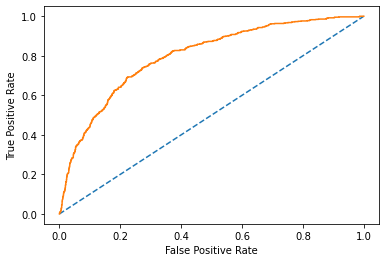

In [112]:
probs = best_grid_nnc.predict_proba(X_train_ncc)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
ann_train_auc = roc_auc_score(train_labels, probs)
print('AUC: %.3f' % ann_train_auc)
# calculate roc curve
ann_train_fpr, ann_train_tpr, cart_train_thresholds = roc_curve(train_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(ann_train_fpr, ann_train_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#### ANN Confusion Matrix for the testing set

In [113]:
confusion_matrix(test_labels, ytest_predict_nnc)

array([[559,  46],
       [181, 114]], dtype=int64)

#### Accuracy of the testing data

In [114]:
ann_test_acc=best_grid_nnc.score(X_test_ncc,test_labels) 
ann_test_acc

0.7477777777777778

#### ANN Classification Report for the testing data

In [115]:
print(classification_report(test_labels, ytest_predict_nnc))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       605
           1       0.71      0.39      0.50       295

    accuracy                           0.75       900
   macro avg       0.73      0.66      0.67       900
weighted avg       0.74      0.75      0.72       900



In [116]:
nn_metrics=classification_report(test_labels, ytest_predict_nnc,output_dict=True)
df=pd.DataFrame(nn_metrics).transpose()
nn_test_precision=round(df.loc["1"][0],2)
nn_test_recall=round(df.loc["1"][1],2)
nn_test_f1=round(df.loc["1"][2],2)
print ('nn_test_precision ',nn_test_precision)
print ('nn_test_recall ',nn_test_recall)
print ('nn_test_f1 ',nn_test_f1)

nn_test_precision  0.71
nn_test_recall  0.39
nn_test_f1  0.5


#### AUC and ROC for the testing data of the ANN

AUC: 0.790


Text(0, 0.5, 'True Positive Rate')

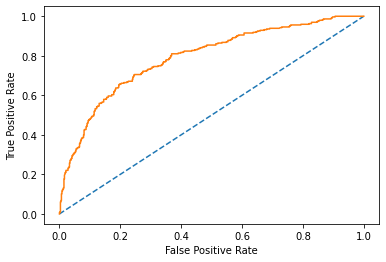

In [117]:
probs = best_grid_nnc.predict_proba(X_test_ncc)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
ann_test_auc = roc_auc_score(test_labels, probs)
print('AUC: %.3f' % ann_test_auc)
# calculate roc curve
ann_test_fpr, ann_test_tpr, cart_train_thresholds = roc_curve(test_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(ann_test_fpr, ann_test_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

### Final Model: Compare all the models and write an inference which model is best/optimized.

#### Comparison of the performance metrics of all 3 models

In [118]:
index=['Accuracy', 'AUC', 'Recall','Precision','F1 Score']
data = pd.DataFrame({'CART Train':[cart_train_acc,cart_train_auc,cart_train_recall,cart_train_precision,cart_train_f1],
        'CART Test':[cart_test_acc,cart_test_auc,cart_test_recall,cart_test_precision,cart_test_f1],
       'Random Forest Train':[rf_train_acc,rf_train_auc,rf_train_recall,rf_train_precision,rf_train_f1],
        'Random Forest Test':[rf_test_acc,rf_test_auc,rf_test_recall,rf_test_precision,rf_test_f1],
       'Neural Network Train':[ann_train_acc,ann_train_auc,nn_train_recall,nn_train_precision,nn_train_f1],
        'Neural Network Test':[ann_test_acc,ann_test_auc,nn_test_recall,nn_test_precision,nn_test_f1]},index=index)
round(data,2)

,CART Train,CART Test,Random Forest Train,Random Forest Test,Neural Network Train,Neural Network Test
Accuracy,0.80,0.76,0.83,0.77,0.77,0.75
AUC,0.84,0.80,0.89,0.82,0.80,0.79
Recall,0.55,0.42,0.63,0.46,0.48,0.39
Precision,0.71,0.72,0.77,0.72,0.65,0.71
F1 Score,0.62,0.53,0.69,0.56,0.55,0.50


#### ROC Curve for the 3 models on the Training data

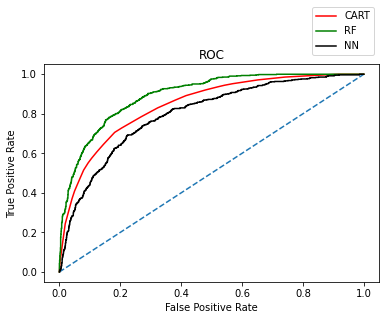

In [119]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(cart_train_fpr, cart_train_tpr,color='red',label="CART")
plt.plot(rf_train_fpr,rf_train_tpr,color='green',label="RF")
plt.plot(ann_train_fpr,ann_train_tpr,color='black',label="NN")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right')

#### ROC Curve for the 3 models on the Test data

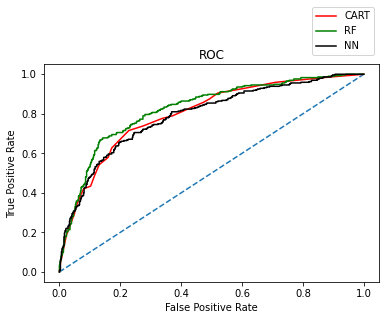

In [120]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(cart_test_fpr, cart_test_tpr,color='red',label="CART")
plt.plot(rf_test_fpr,rf_test_tpr,color='green',label="RF")
plt.plot(ann_test_fpr,ann_test_tpr,color='black',label="NN")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right')

### Inference: Based on the whole Analysis, what are the business insights and recommendations

# Thanks